<a href="https://colab.research.google.com/github/bochendong/giao_bochen/blob/main/unet_recon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import random
from torchvision.utils import save_image
import os
from torch.optim.lr_scheduler import StepLR
import glob
import cv2
import math

from torch.utils.data import Subset

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

small_dataset = True
fraction = 0.02

if (small_dataset):
    UNET_PATH = 'model_weight/unet_small.pth'
    DNN_PATH = 'model_weight/dnn_small.pth'
    num_epochs = 150
else:
    UNET_PATH = 'model_weight/unet.pth'
    DNN_PATH = 'model_weight/dnn.pth'
    num_epochs = 24


# Hyperparameters
BATCH_SIZE = 128

MNIST = True
CIFAR10 = False

# Network Training Settings
Train_BASE_DNN = True
Train_Unet = True

if (os.path.exists(DNN_PATH)) == True:
    Train_BASE_DNN = False

if (os.path.exists(UNET_PATH)) == True:
    Train_Unet = False

In [3]:
if (os.path.exists("./output")) == False:
    os.mkdir("output")

if (os.path.exists("./model_weight")) == False:
    os.mkdir("model_weight")

if (os.path.exists("./test_out")) == False:
    os.mkdir("test_out")

for epoch in range (num_epochs):
    if (os.path.exists("./output/%03d" % epoch)) == False:
        os.mkdir("./output/%03d" % epoch)
    else:
        files = glob.glob("./output/%03d/*.png" % epoch)

        for f in files:
          os.remove(f)

In [4]:
train_dataset = datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor()
                       ]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

test_dataset =  datasets.MNIST('data', train=False, transform=transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor()
                       ]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

if (small_dataset):
    num_samples = int(len(train_dataset) * fraction)
    indices = np.random.choice(len(train_dataset), num_samples, replace=False)

    train_dataset_small = Subset(train_dataset, indices)
    train_loader = torch.utils.data.DataLoader(train_dataset_small, batch_size=BATCH_SIZE, shuffle=True)

    num_epochs = 40


# VGG

In [5]:
class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
def dnn_test(dnn_model, test_loader):
    total = 0
    total_correct = 0

    for i, (images, labels) in enumerate(test_loader):
        images = images.cuda()
        labels = labels.cuda()

        outputs = dnn_model(images)
        
        _, pred = torch.max(outputs, 1)
        correct = pred.eq(labels).cpu().sum().item()
        total_correct += correct
        total += BATCH_SIZE

    return total_correct / total

In [7]:
if (Train_BASE_DNN):
    dnn_epoch = 300
    dnn_model = VGG11().cuda()
    dnn_criterion = nn.CrossEntropyLoss()
    dnn_optimizer = torch.optim.Adam(dnn_model.parameters(), lr=1e-5)

    print("Training DNN classifier...")
    acc_history = []
    test_acc_history = []
    for epoch in range(dnn_epoch):
        total = 0
        total_correct = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda()
            labels = labels.cuda()

            # Forward pass
            outputs = dnn_model(images)
            loss = dnn_criterion(outputs, labels)

            # Backward pass and optimization
            dnn_optimizer.zero_grad()
            loss.backward()
            dnn_optimizer.step()

            _, pred = torch.max(outputs, 1)
            correct = pred.eq(labels).cpu().sum().item()
            total_correct += correct
            total += BATCH_SIZE
        if((epoch + 1) % 10 == 0):
            print("e:", epoch, 'acc:', total_correct / total)
        acc_history.append(total_correct / total)
        test_acc_history.append(dnn_test(dnn_model, test_loader))
    print("DNN classifier training complete.")
    torch.save(dnn_model.state_dict(), DNN_PATH)

Training DNN classifier...
e: 9 acc: 0.11171875
e: 19 acc: 0.54140625
e: 29 acc: 0.64140625
e: 39 acc: 0.659375
e: 49 acc: 0.70078125
e: 59 acc: 0.7265625
e: 69 acc: 0.74765625
e: 79 acc: 0.7765625
e: 89 acc: 0.78984375
e: 99 acc: 0.815625
e: 109 acc: 0.82265625
e: 119 acc: 0.84375
e: 129 acc: 0.85625
e: 139 acc: 0.86953125
e: 149 acc: 0.8828125
e: 159 acc: 0.88828125
e: 169 acc: 0.9
e: 179 acc: 0.90625
e: 189 acc: 0.9109375
e: 199 acc: 0.9140625
e: 209 acc: 0.91953125
e: 219 acc: 0.9265625
e: 229 acc: 0.9171875
e: 239 acc: 0.92578125
e: 249 acc: 0.93515625
e: 259 acc: 0.934375
e: 269 acc: 0.93671875
e: 279 acc: 0.9359375
e: 289 acc: 0.93671875
e: 299 acc: 0.93671875
DNN classifier training complete.


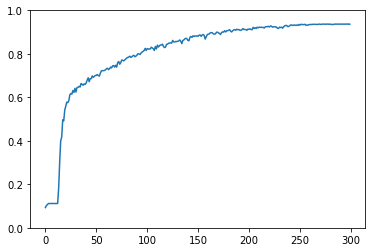

In [8]:
if (Train_BASE_DNN):
    plt.plot(range(0, dnn_epoch), acc_history)
    plt.ylim(0, 1)

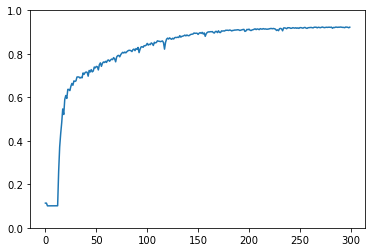

In [9]:
if (Train_BASE_DNN):
    plt.plot(range(0, dnn_epoch), test_acc_history)
    plt.ylim(0, 1)

In [10]:
dnn_model = VGG11().cuda()
dnn_criterion = nn.CrossEntropyLoss()
dnn_model.load_state_dict(torch.load(DNN_PATH))

print("Testing DNN classifier...")
total = 0
total_correct = 0
for i, (images, labels) in enumerate(test_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = dnn_model(images)
    
    _, pred = torch.max(outputs, 1)
    correct = pred.eq(labels).cpu().sum().item()
    total_correct += correct
    total += BATCH_SIZE

print("Test Acc:" , total_correct/total)


print("DNN classifier Test complete.")

Testing DNN classifier...
Test Acc: 0.922676282051282
DNN classifier Test complete.


# Unet

In [11]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.activate = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d((2, 2))
        self.dropout = nn.Dropout(p=0.5)
        self.sigmod = nn.Sigmoid ()
        self.label_embedding = nn.Embedding(10, 512)

        self.encoder_1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding= 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding= 1),
            nn.ReLU(inplace=True),
        )

        self.encoder_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding= 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding= 1),
            nn.ReLU(inplace=True),
        )

        self.encoder_3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding= 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding= 1),
            nn.ReLU(inplace=True),
        )

        self.encoder_4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding= 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding= 1),
            nn.ReLU(inplace=True),
        )
        
        self.middle_1_0 = nn.Conv2d(1024, 1024, 3, padding= 1)
        self.middle_1_1 = nn.Conv2d(1024, 1024, 3, padding= 1)
        
       
        self.deconv4_0 = nn.ConvTranspose2d(1536, 512, 3, stride=(2,2), padding = 1, output_padding = 1)
        self.uconv4_1 = nn.Conv2d(1024, 512, 3, padding= 1) 
        self.uconv4_2 = nn.Conv2d(512, 512, 3, padding= 1)

        self.deconv3_0 = nn.ConvTranspose2d(512, 512, 3, stride=(2,2), padding = 1, output_padding = 1)
        self.uconv3_1 = nn.Conv2d(768, 256, 3, padding= 1) 
        self.uconv3_2 = nn.Conv2d(256, 256, 3, padding= 1)

        self.deconv2_0 = nn.ConvTranspose2d(256, 512, 3, stride=(2,2), padding = 1, output_padding = 1)
        self.uconv2_1 = nn.Conv2d(640, 128, 3, padding= 1) 
        self.uconv2_2 = nn.Conv2d(128, 128, 3, padding= 1)

        self.deconv1_0 = nn.ConvTranspose2d(128, 512, 3, stride=(2,2), padding = 1, output_padding = 1)
        self.uconv1_1 = nn.Conv2d(576, 192, 3, padding= 1) 
        self.uconv1_2 = nn.Conv2d(192, 192, 3, padding= 1)

  
        self.out_layer = nn.Conv2d(192, 1, 1)

 

    def forward(self, x, input_labels, target_labels):
        conv1 = self.encoder_1(x)
        pool1 = self.pool(conv1)
        pool1 = self.dropout(pool1)

        conv2 = self.encoder_2(pool1)
        pool2 = self.pool(conv2)
        pool2 = self.dropout(pool2)

        conv3 = self.encoder_3(pool2)
        pool3 = self.pool(conv3)
        pool3 = self.dropout(pool3)

        conv4 = self.encoder_4(pool3)
        pool4 = self.pool(conv4)
        encoder_out = self.dropout(pool4)

        input_label_embedding = self.label_embedding(input_labels).view(input_labels.size(0), 512, 1, 1)
        x1 = torch.cat([encoder_out, input_label_embedding.expand_as(encoder_out)], dim=1)

        convm = self.middle_1_0(x1)
        convm = self.activate(convm)
        convm = self.middle_1_1(convm)
        x2 = self.activate(convm)

        target_label_embedding = self.label_embedding(target_labels).view(target_labels.size(0), 512, 1, 1)
        x2 = torch.cat([x2, target_label_embedding.expand(x2.size(0), 512, x2.size(2), x2.size(3))], dim=1)

        deconv4 = self.deconv4_0(x2)
        uconv4 = torch.cat([deconv4, conv4], 1)   # (None, 4, 4, 1024)
        uconv4 = self.dropout(uconv4)
        uconv4 = self.uconv4_1(uconv4)            # (None, 4, 4, 512)
        uconv4 = self.activate(uconv4)
        uconv4 = self.uconv4_2(uconv4)            # (None, 4, 4, 512)
        uconv4 = self.activate(uconv4)

        deconv3 = self.deconv3_0(uconv4)          # (None, 8, 8, 512)
        uconv3 = torch.cat([deconv3, conv3], 1)   # (None, 8, 8, 768)
        uconv3 = self.dropout(uconv3)
        uconv3 = self.uconv3_1(uconv3)            # (None, 8, 8, 256)
        uconv3 = self.activate(uconv3)
        uconv3 = self.uconv3_2(uconv3)            # (None, 8, 8, 256)
        uconv3 = self.activate(uconv3)
        
        deconv2 = self.deconv2_0(uconv3)          # (None, 16, 16, 512)
        uconv2 = torch.cat([deconv2, conv2], 1)   # (None, 16, 16, 640)
        uconv2 = self.dropout(uconv2)
        uconv2 = self.uconv2_1(uconv2)            # (None, 16, 16, 128)
        uconv2 = self.activate(uconv2)
        uconv2 = self.uconv2_2(uconv2)            # (None, 16, 16, 128)
        uconv2 = self.activate(uconv2)

        deconv1 = self.deconv1_0(uconv2)          # (None, 32, 32, 512)
        uconv1 = torch.cat([deconv1, conv1], 1)   # (None, 32, 32, 576)
        uconv1 = self.dropout(uconv1)
        uconv1 = self.uconv1_1(uconv1)            # (None, 32, 32, 192)
        uconv1 = self.activate(uconv1)
        uconv1 = self.uconv1_2(uconv1)            # (None, 32, 32, 192)
        uconv1 = self.activate(uconv1)

        out = self.out_layer(uconv1)
        out = self.sigmod(out)

        return out

In [12]:
'''
dataset_iter = iter(train_loader)
test_img, test_label = next(dataset_iter)

target_labels = (test_label + torch.randint(1, 9, size=(BATCH_SIZE,))) % 10

model = UNet()
model(test_img, test_label, target_labels).size()'''


'\ndataset_iter = iter(train_loader)\ntest_img, test_label = next(dataset_iter)\n\ntarget_labels = (test_label + torch.randint(1, 9, size=(BATCH_SIZE,))) % 10\n\nmodel = UNet()\nmodel(test_img, test_label, target_labels).size()'

# Unet geneartion Training

In [13]:
def perceptual_loss(vgg_model, input_images, output_images):
    feature_layers = [vgg_model.features[i] for i in range(len(vgg_model.features))]
    feature_extractor = nn.Sequential(*feature_layers[:-1]).cuda()
    
    input_features = feature_extractor(input_images)
    output_features = feature_extractor(output_images)
    
    return nn.functional.mse_loss(input_features, output_features)

def generate_synthetic_digits(digit, count):
    if (not small_dataset):
        digit_indices = np.where(train_dataset.targets.cpu() == digit.cpu())[0]
    else:
        all_digit_indices = np.where(train_dataset_small.dataset.targets.cpu() == digit.cpu())[0]
        digit_indices = np.intersect1d(all_digit_indices, indices)
    
    if len(digit_indices) == 0:
        raise ValueError(f"No samples found for label {digit.item()}")
        
    selected_indices = np.random.choice(digit_indices, count, replace=True)
    synthetic_digits = torch.stack([train_dataset[i][0] for i in selected_indices])
    return synthetic_digits

# Erode the input images to remove the digit information
def erode_images(images):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    eroded_images = []
    for image in images:
        gray_image = image.squeeze(0).detach().cpu().numpy()
        eroded_image = cv2.erode(gray_image, kernel, iterations=1)
        eroded_images.append(eroded_image)
    
    eroded_images_np = np.array(eroded_images)
    return torch.tensor(eroded_images_np).unsqueeze(1).cuda()

e: 0
loss: 6.8514833 recon loss: 0.709689 dnn loss: 5.992548942565918 p loss: 0.14924536645412445
loss: 6.378127 recon loss: 0.7084529 dnn loss: 5.505949020385742 p loss: 0.16372519731521606
loss: 6.161673 recon loss: 0.7072042 dnn loss: 5.289477825164795 p loss: 0.164991095662117
loss: 6.9114137 recon loss: 0.70615613 dnn loss: 6.040236473083496 p loss: 0.16502085328102112
loss: 6.776921 recon loss: 0.70482147 dnn loss: 5.893746852874756 p loss: 0.1783522367477417
e: 1
loss: 6.3641396 recon loss: 0.70351946 dnn loss: 5.498940467834473 p loss: 0.16167987883090973
loss: 6.298952 recon loss: 0.70209193 dnn loss: 5.431772232055664 p loss: 0.16508783400058746
loss: 6.5429945 recon loss: 0.7005896 dnn loss: 5.6593918800354 p loss: 0.18301275372505188
loss: 5.910882 recon loss: 0.69914126 dnn loss: 5.04698371887207 p loss: 0.1647569090127945
loss: 6.414394 recon loss: 0.6975538 dnn loss: 5.569738864898682 p loss: 0.14710159599781036
e: 2
loss: 6.1169934 recon loss: 0.6958587 dnn loss: 5.2544

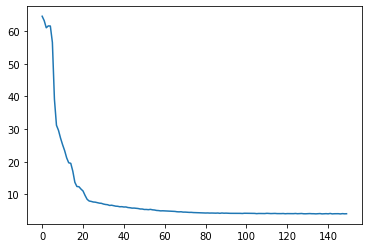

In [14]:
# Training loop
if (Train_Unet):
    # Initialize model, loss, and optimizer
    model = UNet().cuda()
    dnn_model = VGG11().cuda()
    dnn_model.load_state_dict(torch.load(DNN_PATH))
    dnn_criterion = nn.CrossEntropyLoss()

    # Freeze the DNN classifier weights
    for param in dnn_model.parameters():
        param.requires_grad = False

    # Hyperparameters
    alpha = 0.5
    beta = 0.5

    if (small_dataset):
        num_epochs = 150
        print_epoch = 2
        learning_rate = 1e-5
        step_size = 20
        gamma = 0.7
    else:
        num_epochs = 24
        learning_rate = 3e-6
        print_epoch = 50
        step_size = 8
        gamma = 0.15

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    loss_history = []
    for epoch in range(num_epochs):
        print('e:' , epoch)
        epoch_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda()
            labels = labels.cuda()

            target_labels = (labels + torch.randint(1, 9, size=(labels.size(0),)).cuda()) % 10

            outputs = model(images, labels, target_labels)
            
            # Generate target images (same digit as target labels)
            eroded_images = erode_images(images)
            synthetic_target_digits = torch.cat([generate_synthetic_digits(d, 1) for d in target_labels]).cuda()
            target_images = (eroded_images + synthetic_target_digits) / 2

            # Compute loss
            reconstruction_loss = criterion(outputs, target_images)
            classification_loss = dnn_criterion(dnn_model(outputs), target_labels)
            p_loss = perceptual_loss(dnn_model, images, outputs)

            loss = reconstruction_loss + alpha * classification_loss + beta * p_loss
            epoch_loss+= loss.data.cpu().numpy()
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % print_epoch == 0:
                print('loss:' , loss.data.cpu().numpy(), 'recon loss:', 
                    reconstruction_loss.data.cpu().numpy(), 
                    'dnn loss:', alpha * classification_loss.data.cpu().numpy(),
                    'p loss:', beta * p_loss.data.cpu().numpy())
                save_image(outputs.data, './output/%03d/%04d_recon.png' % ( epoch, i))
                save_image(images.data, './output/%03d/%04d_img.png' % ( epoch, i))
                save_image(target_images.data, './output/%03d/%04d_target.png' % ( epoch, i))
        
        scheduler.step()

        loss_history.append(epoch_loss)
    torch.save(model.state_dict(), UNET_PATH)

    plt.plot(range(0, num_epochs), loss_history)

# Test for Unet Generation

In [15]:
model = UNet().cuda()
model.load_state_dict(torch.load(UNET_PATH))

<All keys matched successfully>

In [16]:
def save_recon_img(test_img, test_label, batch_number):
    for label in range (0, 10):
        target_label = torch.ones(BATCH_SIZE, dtype=torch.int) * label

        test_img = test_img.cuda()
        test_label = test_label.cuda()
        target_label = target_label.cuda()


        out = model(test_img, test_label, target_label)

        save_image(test_img.data, './test_out/%d_%d_img.png' % (batch_number, label))
        save_image(out.data, './test_out/%d_%d_recon.png' % (batch_number, label))

dataset_iter = iter(test_loader)

test_img_0, test_label_0 = next(dataset_iter)
test_img_1, test_label_1 = next(dataset_iter)

In [17]:
save_recon_img(test_img_0, test_label_0, 0)

In [18]:
save_recon_img(test_img_1, test_label_1, 1)

In [19]:
'''%%capture
!zip -r /content/train_out.zip /content/output
!zip -r /content/model_weight.zip /content/model_weight
!zip -r /content/test_out.zip /content/test_out'''

'%%capture\n!zip -r /content/train_out.zip /content/output\n!zip -r /content/model_weight.zip /content/model_weight\n!zip -r /content/test_out.zip /content/test_out'

# Train By Test

In [20]:
def generate_augmented_test_images(model, test_loader, num_augmented_images=1000):
    augmented_images = []
    augmented_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda()
            labels = labels.cuda()

            target_labels = (labels + torch.randint(1, 9, size=(BATCH_SIZE,)).cuda()) % 10
            outputs = model(images, labels, target_labels)
            
            augmented_images.append(outputs.cpu())
            augmented_labels.append(target_labels.cpu())
            
            if len(augmented_images) * BATCH_SIZE >= num_augmented_images:
                break
    
    augmented_images = torch.cat(augmented_images)[:num_augmented_images]
    augmented_labels = torch.cat(augmented_labels)[:num_augmented_images]
    
    return augmented_images, augmented_labels

augmented_test_images, augmented_test_labels = generate_augmented_test_images(model, test_loader)


In [21]:
if (small_dataset):
    resized_train_images = torch.stack([train_dataset_small.dataset[i][0] for i in indices])
    
    train_images = torch.cat([resized_train_images, augmented_test_images])
    train_labels = torch.cat([torch.tensor(train_dataset_small.dataset.targets )[indices], augmented_test_labels])
else:
    resized_train_images = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])

    train_images = torch.cat([resized_train_images, augmented_test_images])
    train_labels = torch.cat([torch.tensor(train_dataset.targets ), augmented_test_labels])

C:\Users\55366\AppData\Local\Temp\ipykernel_24772\1920080413.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.cat([torch.tensor(train_dataset_small.dataset.targets )[indices], augmented_test_labels])


In [22]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
train_dataset_extended = TensorDataset(train_images, train_labels)
train_loader_extended = DataLoader(train_dataset_extended, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [29]:
dnn_model = VGG11().cuda()  # Define your classifier (e.g., a CNN)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=1e-5)

def dnn_test(dnn_model, test_loader):
    total = 0
    total_correct = 0

    for i, (images, labels) in enumerate(test_loader):
        images = images.cuda()
        labels = labels.cuda()

        outputs = dnn_model(images)
        
        _, pred = torch.max(outputs, 1)
        correct = pred.eq(labels).cpu().sum().item()
        total_correct += correct
        total += BATCH_SIZE

    return total_correct / total

# Training loop for the new classifier
acc_history = []
test_acc_history = []
for epoch in range(300):
    total_correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader_extended):
        images = images.cuda()
        labels = labels.cuda()

        # Forward pass
        outputs = dnn_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, pred = torch.max(outputs, 1)
        correct = pred.eq(labels).cpu().sum().item()
        total_correct += correct
        total += BATCH_SIZE

    if((epoch + 1 )% 10 == 0):
        print("e:", epoch, 'acc:', total_correct / total)
    acc_history.append(total_correct / total)
    test_acc_history.append(dnn_test(dnn_model, test_loader))

e: 9 acc: 0.5836397058823529
e: 19 acc: 0.8106617647058824
e: 29 acc: 0.8616727941176471
e: 39 acc: 0.8782169117647058
e: 49 acc: 0.8970588235294118
e: 59 acc: 0.9099264705882353
e: 69 acc: 0.9306066176470589
e: 79 acc: 0.9402573529411765
e: 89 acc: 0.9517463235294118
e: 99 acc: 0.9577205882352942
e: 109 acc: 0.9641544117647058
e: 119 acc: 0.9669117647058824
e: 129 acc: 0.9765625
e: 139 acc: 0.9770220588235294
e: 149 acc: 0.9834558823529411
e: 159 acc: 0.9889705882352942
e: 169 acc: 0.9926470588235294
e: 179 acc: 0.9931066176470589
e: 189 acc: 0.9963235294117647
e: 199 acc: 0.9977022058823529
e: 209 acc: 0.9967830882352942
e: 219 acc: 0.9972426470588235
e: 229 acc: 0.9986213235294118
e: 239 acc: 0.9990808823529411
e: 249 acc: 0.9977022058823529
e: 259 acc: 1.0
e: 269 acc: 1.0
e: 279 acc: 1.0
e: 289 acc: 1.0
e: 299 acc: 1.0


(0.0, 1.0)

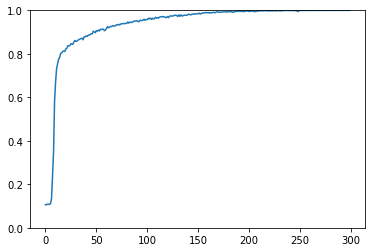

In [30]:
plt.plot(range(0, 300), acc_history)
plt.ylim(0, 1)

[0.09805689102564102,
 0.09805689102564102,
 0.09805689102564102,
 0.09805689102564102,
 0.09805689102564102,
 0.09885817307692307,
 0.13201121794871795,
 0.24068509615384615,
 0.4651442307692308,
 0.5513822115384616,
 0.5873397435897436,
 0.6305088141025641,
 0.6475360576923077,
 0.6408253205128205,
 0.6600560897435898,
 0.6692708333333334,
 0.6733774038461539,
 0.6814903846153846,
 0.6851963141025641,
 0.6806891025641025,
 0.6818910256410257,
 0.696113782051282,
 0.7077323717948718,
 0.7114383012820513,
 0.7026241987179487,
 0.719551282051282,
 0.7162459935897436,
 0.7189503205128205,
 0.7297676282051282,
 0.7287660256410257,
 0.7408854166666666,
 0.7424879807692307,
 0.7462940705128205,
 0.7559094551282052,
 0.7593149038461539,
 0.7616185897435898,
 0.7478966346153846,
 0.7669270833333334,
 0.7708333333333334,
 0.7718349358974359,
 0.780448717948718,
 0.7880608974358975,
 0.7737379807692307,
 0.7910657051282052,
 0.7979767628205128,
 0.7980769230769231,
 0.8002804487179487,
 0.79917

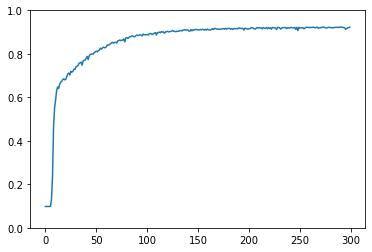

In [31]:
plt.plot(range(0, 300), test_acc_history)
plt.ylim(0, 1)
test_acc_history

In [32]:
print("Testing DNN classifier...")
total = 0
total_correct = 0

for i, (images, labels) in enumerate(test_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = dnn_model(images)
    
    _, pred = torch.max(outputs, 1)
    correct = pred.eq(labels).cpu().sum().item()
    total_correct += correct
    total += BATCH_SIZE

print("Test Acc:" , total_correct/total)


print("DNN classifier Test complete.")

Testing DNN classifier...
Test Acc: 0.9231770833333334
DNN classifier Test complete.
